# 🤖 RL Agent Training with PPO

**Purpose:** Train a Reinforcement Learning agent using Proximal Policy Optimization (PPO) to learn optimal pricing.

**What we'll do:**
1. Import the DynamicPricingEnv from previous notebook
2. Initialize PPO agent from Stable-Baselines3
3. Train the agent for multiple timesteps
4. Save the trained model
5. Visualize learning progress

---

## 1. Import Required Libraries

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import os

np.random.seed(42)

print("✅ Libraries imported successfully!")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


✅ Libraries imported successfully!


## 2. Copy DynamicPricingEnv Class

We need to redefine the environment class in this notebook.

In [2]:
class DynamicPricingEnv(gym.Env):
    """Custom Gym Environment for Dynamic Pricing"""
    
    def __init__(self, max_days=365):
        super(DynamicPricingEnv, self).__init__()
        
        self.max_days = max_days
        self.current_day = 0
        self.last_price = 100
        
        self.min_price = 50
        self.max_price = 150
        self.price_step = 10
        self.prices = np.arange(self.min_price, self.max_price + 1, self.price_step)
        
        self.base_demand = 1000
        self.optimal_price = 100
        self.price_elasticity = -1.5
        
        self.action_space = spaces.Discrete(len(self.prices))
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([1, 1, 1]),
            dtype=np.float32
        )
        
    def _get_competitor_price(self):
        competitor_price = self.optimal_price + np.random.normal(0, 15)
        return np.clip(competitor_price, self.min_price, self.max_price)
    
    def _get_seasonal_factor(self):
        return 1 + 0.3 * np.sin(2 * np.pi * self.current_day / 365)
    
    def _calculate_demand(self, price, competitor_price):
        price_ratio = price / self.optimal_price
        elasticity_effect = np.power(price_ratio, self.price_elasticity)
        seasonal_factor = self._get_seasonal_factor()
        competitor_effect = 1 - 0.2 * (competitor_price < price)
        demand = self.base_demand * elasticity_effect * seasonal_factor * competitor_effect
        noise = np.random.normal(1, 0.1)
        demand = demand * noise
        return max(0, demand)
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_day = 0
        self.last_price = 100
        observation = self._get_observation()
        info = {}
        return observation, info
    
    def _get_observation(self):
        competitor_price = self._get_competitor_price()
        obs = np.array([
            self.current_day / self.max_days,
            (self.last_price - self.min_price) / (self.max_price - self.min_price),
            (competitor_price - self.min_price) / (self.max_price - self.min_price)
        ], dtype=np.float32)
        return obs
    
    def step(self, action):
        price = self.prices[action]
        competitor_price = self._get_competitor_price()
        demand = self._calculate_demand(price, competitor_price)
        revenue = price * demand
        reward = revenue / 1000
        
        self.last_price = price
        self.current_day += 1
        
        terminated = self.current_day >= self.max_days
        truncated = False
        observation = self._get_observation()
        
        info = {
            'price': price,
            'demand': demand,
            'revenue': revenue,
            'competitor_price': competitor_price,
            'day': self.current_day
        }
        
        return observation, reward, terminated, truncated, info

print("✅ DynamicPricingEnv class defined!")

✅ DynamicPricingEnv class defined!


## 3. Create Custom Callback for Training Visualization

This callback will track rewards during training.

In [3]:
class RewardCallback(BaseCallback):
    """
    Custom callback for tracking rewards during training
    """
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.current_rewards = []
        
    def _on_step(self):
        # Get the last reward
        reward = self.locals['rewards'][0]
        self.current_rewards.append(reward)
        
        # Check if episode is done
        done = self.locals['dones'][0]
        if done:
            episode_reward = sum(self.current_rewards)
            episode_length = len(self.current_rewards)
            
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(episode_length)
            self.current_rewards = []
            
            if self.verbose > 0:
                print(f"Episode {len(self.episode_rewards)}: Reward = {episode_reward:.2f}, Length = {episode_length}")
        
        return True

print("✅ RewardCallback class defined!")

✅ RewardCallback class defined!


## 4. Initialize Environment and PPO Agent

In [4]:
# Create environment
env = DynamicPricingEnv(max_days=365)

print("🎮 Environment created!")
print(f"   Action Space: {env.action_space}")
print(f"   Observation Space: {env.observation_space}")

# Initialize PPO agent
model = PPO(
    "MlpPolicy",  # Multi-Layer Perceptron policy
    env,
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    verbose=1,
    seed=42
)

print("\n🤖 PPO Agent initialized!")
print(f"   Policy: MlpPolicy")
print(f"   Learning Rate: 0.0003")
print(f"   Gamma (Discount Factor): 0.99")

🎮 Environment created!
   Action Space: Discrete(11)
   Observation Space: Box(0.0, 1.0, (3,), float32)
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

🤖 PPO Agent initialized!
   Policy: MlpPolicy
   Learning Rate: 0.0003
   Gamma (Discount Factor): 0.99


## 5. Train the Agent

Training for 100,000 timesteps (approximately 273 episodes with 365 days each).

In [5]:
# Create callback
callback = RewardCallback(verbose=0)

# Train the model
print("🚀 Starting training...")
print("   Total timesteps: 100,000")
print("   This may take a few minutes...\n")

TOTAL_TIMESTEPS = 100_000

model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=callback,
    progress_bar=True
)

print("\nTraining completed!")
print(f"   Total episodes: {len(callback.episode_rewards)}")
print(f"   Average reward: {np.mean(callback.episode_rewards):.2f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

🚀 Starting training...
   Total timesteps: 100,000
   This may take a few minutes...

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 365      |
|    ep_rew_mean     | 3.5e+04  |
| time/              |          |
|    fps             | 6768     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.49e+04      |
| time/                   |               |
|    fps                  | 4935          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00012812097 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
| 


Training completed!
   Total episodes: 274
   Average reward: 36317.75


## 6. Visualize Learning Progress

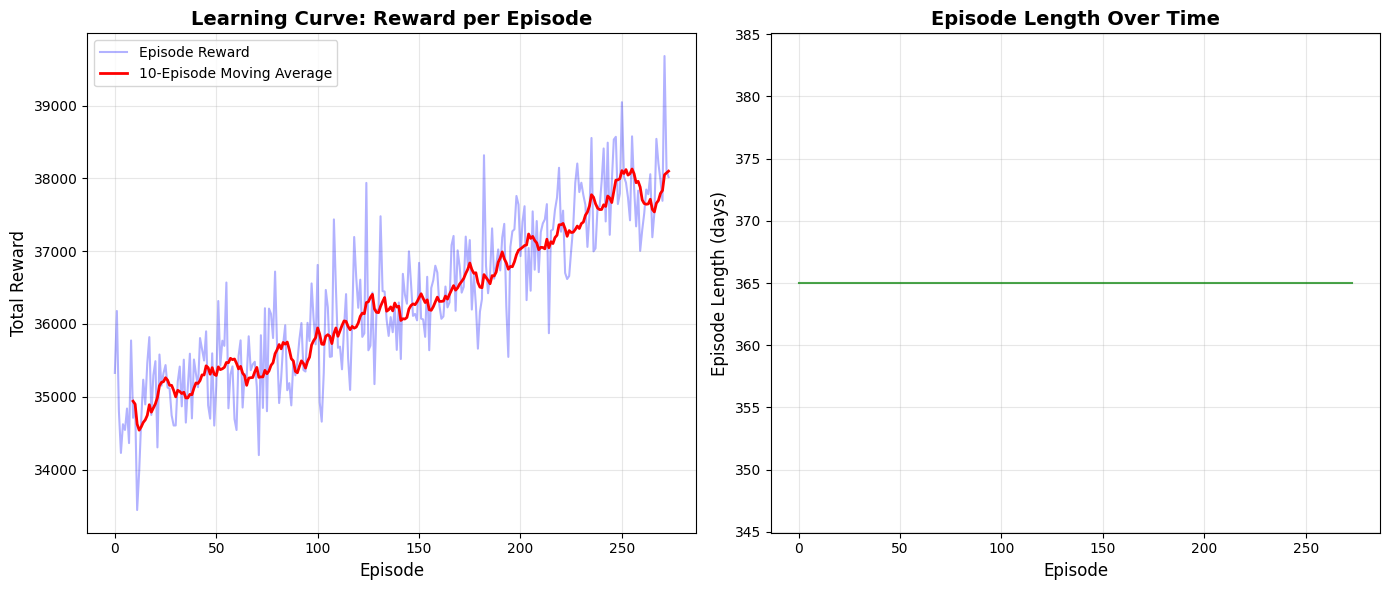

✅ Learning curve saved to visuals/reward_curve.png


In [6]:
# Plot learning curve
plt.figure(figsize=(14, 6))

# Moving average window
window = 10
rewards_smooth = np.convolve(callback.episode_rewards, np.ones(window)/window, mode='valid')

plt.subplot(1, 2, 1)
plt.plot(callback.episode_rewards, alpha=0.3, color='blue', label='Episode Reward')
plt.plot(range(window-1, len(callback.episode_rewards)), rewards_smooth, 
         color='red', linewidth=2, label=f'{window}-Episode Moving Average')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Total Reward', fontsize=12)
plt.title('Learning Curve: Reward per Episode', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(callback.episode_lengths, alpha=0.7, color='green')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Episode Length (days)', fontsize=12)
plt.title('Episode Length Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visuals/reward_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Learning curve saved to visuals/reward_curve.png")

## 7. Save the Trained Model

In [7]:
# Save the trained model
model_path = '../saved_models/pricing_agent_ppo'
model.save(model_path)

print(f"✅ Model saved successfully to: {model_path}.zip")
print(f"💾 File size: {os.path.getsize(model_path + '.zip') / 1024:.2f} KB")
print("\n🎉 Training complete! The agent is ready for evaluation.")

✅ Model saved successfully to: ../saved_models/pricing_agent_ppo.zip
💾 File size: 141.62 KB

🎉 Training complete! The agent is ready for evaluation.
